In [1]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install --upgrade pip
!pip install nest-asyncio
!pip install pyfluidsynth

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [2]:
!git clone --branch=main https://github.com/google-research/t5x
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

Cloning into 't5x'...
remote: Enumerating objects: 860, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 860 (delta 188), reused 175 (delta 175), pack-reused 635
Receiving objects: 100% (860/860), 5.92 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (586/586), done.
Obtaining file:///content
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/google/CommonLoopUtils to /tmp/pip-install-6n8ue65s/clu_a3410e83d0e24fc59e292687220709db
  Running command git clone --filter=blob:none -q https://github.com/google/CommonLoopUtils /tmp/pip-install-6n8ue65s/clu_a3410e83d0e24fc59e292687220709db
  Resolved https://github.com/google/CommonLoopUtils to commit de8023f56be4b843adb066e4f9a6c26d8fe3e874
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 207 kB 5.2 MB/s            
     |████████████████████████████████| 289 kB 66.6 MB/s            
     |████████████████████████████████| 153

In [3]:
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

Cloning into 'mt3'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 104 (delta 44), reused 90 (delta 30), pack-reused 0
Receiving objects: 100% (104/104), 86.89 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Obtaining file:///content
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 200 kB 5.5 MB/s            
     |████████████████████████████████| 87 kB 5.7 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 210 kB 49.9 MB/s            
     |████████████████████████████████| 5.6 MB 51.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 77 kB 5.1 MB/s             
     |████████████████████████████████| 3.6 MB 36.2 MB/s            
     |████████████████████████████████| 1.1 MB 71.5 MB/s            
     |████████████████████████████████| 96 

In [4]:
!gsutil -q -m cp -r gs://mt3/checkpoints .

In [5]:
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

In [6]:
import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.ModelBasedPjitPartitioner(
        model_parallel_submesh=(1, 1, 1, 1), num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens


In [ ]:
MODEL = "mt3" 

checkpoint_path = f'/content/checkpoints/{MODEL}/'

inference_model = InferenceModel(checkpoint_path, MODEL)

/usr/local/lib/python3.7/dist-packages/jax/_src/lib/xla_bridge.py:413: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "


In [111]:
audio = upload_audio(sample_rate=SAMPLE_RATE)
note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

Saving 9089.wav to 9089 (1).wav


Transcription inference

In [112]:
est_ns = inference_model(audio)

# note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, 
#                        sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
note_seq.plot_sequence(est_ns)

Quality assesment

In [57]:
from mt3 import metrics
import pandas as pd


In [114]:
ref_ns = note_seq.midi_file_to_note_sequence(paths[i])

In [73]:
note_seq.plot_sequence(ref_ns)

In [37]:
vocabularies.PROGRAM_GRANULARITIES

{'flat': ProgramGranularity(tokens_map_fn=<function drop_programs at 0x7fddb5292320>, program_map_fn=<function <lambda> at 0x7fddb525eb90>),
 'full': ProgramGranularity(tokens_map_fn=<function <lambda> at 0x7fddb52924d0>, program_map_fn=<function <lambda> at 0x7fddb5292830>),
 'midi_class': ProgramGranularity(tokens_map_fn=<function programs_to_midi_classes at 0x7fddb52923b0>, program_map_fn=<function <lambda> at 0x7fddb5292950>)}

In [67]:
# metrix = []

In [115]:
metrix.append(metrics._program_aware_note_scores(ref_ns, est_ns, 'flat'))

In [ ]:
metrix

In [122]:
pd.DataFrame(metrix).drop(columns = ['Drum onset F1 (flat)','Drum onset precision (flat)','Drum onset recall (flat)'])

,Onset + offset + program precision (flat),Onset + offset + program recall (flat),Onset + offset + program F1 (flat),Nondrum onset + offset + program precision (flat),Nondrum onset + offset + program recall (flat),Nondrum onset + offset + program F1 (flat)
0,0.554622,0.515625,0.534413,0.554622,0.515625,0.534413
1,0.648241,0.575893,0.609929,0.648241,0.575893,0.609929
2,0.608479,0.566125,0.586538,0.608479,0.566125,0.586538
3,0.627907,0.642857,0.635294,0.627907,0.642857,0.635294
4,0.340336,0.222527,0.269103,0.340336,0.222527,0.269103
5,0.134058,0.088095,0.106322,0.134058,0.088095,0.106322
6,0.524064,0.457944,0.488778,0.524064,0.457944,0.488778
7,0.776398,0.710227,0.741840,0.776398,0.710227,0.741840
8,0.747913,0.715655,0.731429,0.747913,0.715655,0.731429
9,0.212598,0.106719,0.142105,0.212598,0.106719,0.142105


Files collection

In [ ]:
!pip install midi2audio
!pip install fluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4514 sha256=441dfbafb4aaa5c18d6209b2cccb9091eb617fc629b71b6db5addbe1d71daa94
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built fluidsynth


In [13]:
from pathlib import Path
from typing import List
import music21
import pretty_midi
from midi2audio import FluidSynth

In [14]:
def collect_children(path: Path) -> List[Path]:
    if path.is_file():
        return [path]
    else:
        result = []
        for child in path.iterdir():
            if child.is_file():
                result.append(child)
            elif child.is_dir():
                result.extend(collect_children(child))
        return result

In [ ]:
def midi2wav(midi_file: Path, wav_file: Path) -> None:
    FluidSynth(sound_font='GeneralUser GS 1.471/GeneralUser GS v1.471.sf2', sample_rate=8000).midi_to_audio(midi_file, wav_file)

In [58]:
def plot_pianoroll(path: Path, title: str = '') -> None:
    ext = path.suffix
    midi_file = path if ext == '.mid' else Path('tmp') / f'{path.stem}.mid'
    if ext == '.abc' and not midi_file.is_file():
        abc2midi(path, midi_file)
    if midi_file.is_file():
        music21.converter.parse(midi_file).plot('pianoroll', title=title)

In [59]:
paths = collect_children(Path('/content/drive/MyDrive/SMLT/music/'))

In [60]:
for i in range(len(paths)):
  print(f'{i}, {paths[i]}')

0, /content/drive/MyDrive/SMLT/music/10198.mid
1, /content/drive/MyDrive/SMLT/music/8927.mid
2, /content/drive/MyDrive/SMLT/music/8908.mid
3, /content/drive/MyDrive/SMLT/music/9425.mid
4, /content/drive/MyDrive/SMLT/music/9130.mid
5, /content/drive/MyDrive/SMLT/music/9519.mid
6, /content/drive/MyDrive/SMLT/music/9336.mid
7, /content/drive/MyDrive/SMLT/music/9662.mid
8, /content/drive/MyDrive/SMLT/music/9089.mid
9, /content/drive/MyDrive/SMLT/music/8912.mid
10, /content/drive/MyDrive/SMLT/music/9336.wav
11, /content/drive/MyDrive/SMLT/music/9425.wav
12, /content/drive/MyDrive/SMLT/music/8908.wav
13, /content/drive/MyDrive/SMLT/music/9130.wav
14, /content/drive/MyDrive/SMLT/music/9519.wav
15, /content/drive/MyDrive/SMLT/music/8912.wav
16, /content/drive/MyDrive/SMLT/music/9089.wav
17, /content/drive/MyDrive/SMLT/music/8927.wav
18, /content/drive/MyDrive/SMLT/music/10198.wav
19, /content/drive/MyDrive/SMLT/music/9662.wav


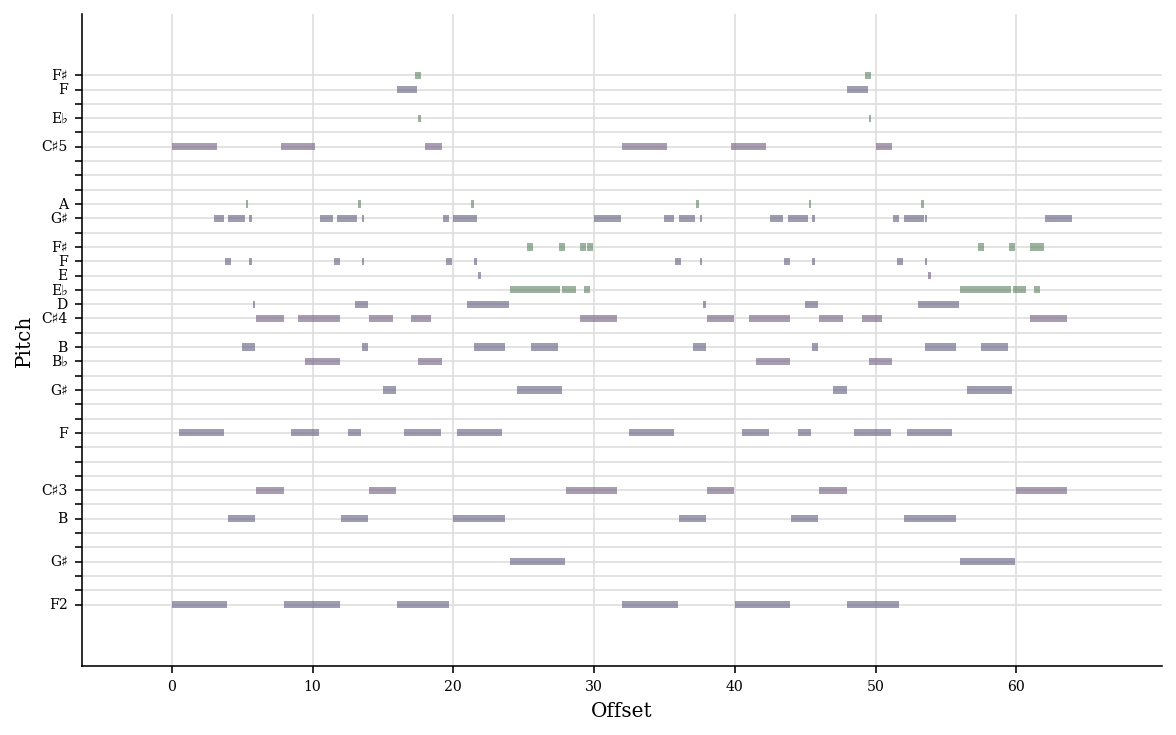

In [ ]:
plot_pianoroll(paths[12])